# Code Execution*

이 섹션에서는 코드 생성 및 실행을 처리하기 위한 맞춤형 에이전트를 만드는 방법을 알아봅니다.  
이 작업들은 {py:meth}`~autogen_agentchat.agents.AssistantAgent`, {py:meth}`~autogen_agentchat.agents.CodeExecutorAgent`에서 제공하는 에이전트 구현을 통해 수행할 수 있지만, 본 가이드는 이들의 기능을 대체할 수 있는 맞춤형 경량 에이전트를 구현하는 방법을 보여줍니다.  
이 간단한 예제에서는 Tesla와 Nvidia의 주식 수익률 플롯을 생성하는 두 에이전트를 구현합니다.

먼저 에이전트 클래스와 메시지 처리를 위한 각각의 절차를 정의합니다.  
두 개의 에이전트 클래스, `Assistant`와 `Executor`를 생성합니다. `Assistant` 에이전트는 코드를 작성하고, `Executor` 에이전트는 코드를 실행합니다.  
또한 에이전트 간에 전달되는 메시지를 정의하는 `Message` 데이터 클래스도 생성합니다.

```{attention}
이 예제에서 생성된 코드는 [Docker](https://www.docker.com/) 컨테이너 내에서 실행됩니다. 예제를 실행하기 전에 Docker가 [설치](https://docs.docker.com/get-started/get-docker/)되어 있고 실행 중인지 확인하십시오. 로컬 코드 실행 기능({py:class}`~autogen_ext.code_executors.local.LocalCommandLineCodeExecutor`)도 제공되지만, LLM이 생성한 코드를 로컬 환경에서 실행할 위험이 있으므로 권장하지 않습니다.
```


In [8]:
import re
from dataclasses import dataclass
from typing import List

from autogen_core import DefaultTopicId, MessageContext, RoutedAgent, default_subscription, message_handler
from autogen_core.code_executor import CodeBlock, CodeExecutor
from autogen_core.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    SystemMessage,
    UserMessage,
)


@dataclass
class Message:
    content: str


@default_subscription
class Assistant(RoutedAgent):
    def __init__(self, model_client: ChatCompletionClient) -> None:
        super().__init__("An assistant agent.")
        self._model_client = model_client
        self._chat_history: List[LLMMessage] = [
            SystemMessage(
                content="""Write Python script in markdown block, and it will be executed.
                You MUST write the code in markdown block. Don't write general text except the code.
                Always save figures to file in the current directory. 
                You can use yfinance to get stock data.
                Do not use plt.show(). 
                If you use plt.savefig(), file name must be result.png')
                All code required to complete this task must be contained within a single response.""",
            )
        ]

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        self._chat_history.append(UserMessage(content=message.content, source="user"))
        result = await self._model_client.create(self._chat_history)
        print(f"\n{'-'*80}\nAssistant:\n{result.content}")
        self._chat_history.append(AssistantMessage(content=result.content, source="assistant"))  # type: ignore
        await self.publish_message(Message(content=result.content), DefaultTopicId())  # type: ignore


def extract_markdown_code_blocks(markdown_text: str) -> List[CodeBlock]:
    pattern = re.compile(r"```(?:\s*([\w\+\-]+))?\n([\s\S]*?)```")
    matches = pattern.findall(markdown_text)
    code_blocks: List[CodeBlock] = []
    for match in matches:
        language = match[0].strip() if match[0] else ""
        code_content = match[1]
        code_blocks.append(CodeBlock(code=code_content, language=language))
    return code_blocks


@default_subscription
class Executor(RoutedAgent):
    def __init__(self, code_executor: CodeExecutor) -> None:
        super().__init__("An executor agent.")
        self._code_executor = code_executor

    @message_handler
    async def handle_message(self, message: Message, ctx: MessageContext) -> None:
        code_blocks = extract_markdown_code_blocks(message.content)
        if code_blocks:
            result = await self._code_executor.execute_code_blocks(
                code_blocks, cancellation_token=ctx.cancellation_token
            )
            print(f"\n{'-'*80}\nExecutor:\n{result.output}")
            await self.publish_message(Message(content=result.output), DefaultTopicId())

You might have already noticed, the agents' logic, whether it is using model or code executor,
is completely decoupled from
how messages are delivered. This is the core idea: the framework provides
a communication infrastructure, and the agents are responsible for their own
logic. We call the communication infrastructure an **Agent Runtime**.

Agent runtime is a key concept of this framework. Besides delivering messages,
it also manages agents' lifecycle. 
So the creation of agents are handled by the runtime.

The following code shows how to register and run the agents using 
{py:class}`~autogen_core.SingleThreadedAgentRuntime`,
a local embedded agent runtime implementation.


In [9]:
import tempfile
import os
from dotenv import load_dotenv

from autogen_core import SingleThreadedAgentRuntime
from autogen_ext.code_executors.docker import DockerCommandLineCodeExecutor
from autogen_ext.models.openai import AzureOpenAIChatCompletionClient

work_dir = tempfile.mkdtemp()

load_dotenv()

api_version = os.getenv("AZURE_OPENAI_API_VERSION")
api_key = os.getenv("AZURE_OPENAI_API_KEY")
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
azure_openai_chat_completion_client = AzureOpenAIChatCompletionClient(
            model="gpt-4o",
            azure_endpoint=azure_endpoint,
            api_version=api_version,
            api_key=api_key
)

runtime = SingleThreadedAgentRuntime()

async with DockerCommandLineCodeExecutor(work_dir=work_dir) as executor: 
    await Assistant.register(
        runtime,
        "assistant",
        lambda: Assistant(azure_openai_chat_completion_client),
    )
    
    await Executor.register(runtime, "executor", lambda: Executor(executor))
    runtime.start()
    
    await runtime.publish_message(
        Message("2025년 1월 이후 마이크로소프트와 애플 주가를 그래프로 비교해줘."), DefaultTopicId()
    )
    await runtime.stop_when_idle()

/var/folders/pr/hngks2mn74d25jycvx6rxl400000gn/T/ipykernel_91497/1443988148.py:41: UserWarning: Resolved model mismatch: gpt-4o-2024-08-06 != gpt-4o-2024-11-20. Model mapping in autogen_ext.models.openai may be incorrect. Set the model to gpt-4o-2024-11-20 to enhance token/cost estimation and suppress this warning.
  result = await self._model_client.create(self._chat_history)



--------------------------------------------------------------------------------
Assistant:
```python
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch stock data for Microsoft and Apple from 2025-01-01 onward
start_date = "2025-01-01"
msft = yf.download("MSFT", start=start_date)
apple = yf.download("AAPL", start=start_date)

# Plot the adjusted closing prices of Microsoft and Apple
plt.figure(figsize=(12, 6))
plt.plot(msft['Adj Close'], label='Microsoft (MSFT)', color='blue')
plt.plot(apple['Adj Close'], label='Apple (AAPL)', color='red')

# Add labels, title, legend, and grid
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price (USD)")
plt.title("Comparison of Microsoft and Apple Stock Prices After January 2025")
plt.legend()
plt.grid()

# Save the figure
plt.savefig('result.png')
```

--------------------------------------------------------------------------------
Executor:
Traceback (most recent call last):
  File "/workspace/tmp_code_152c0cd8616143c21d6277188efa556a

From the agent's output, we can see the plot of Tesla's and Nvidia's stock returns
has been created.

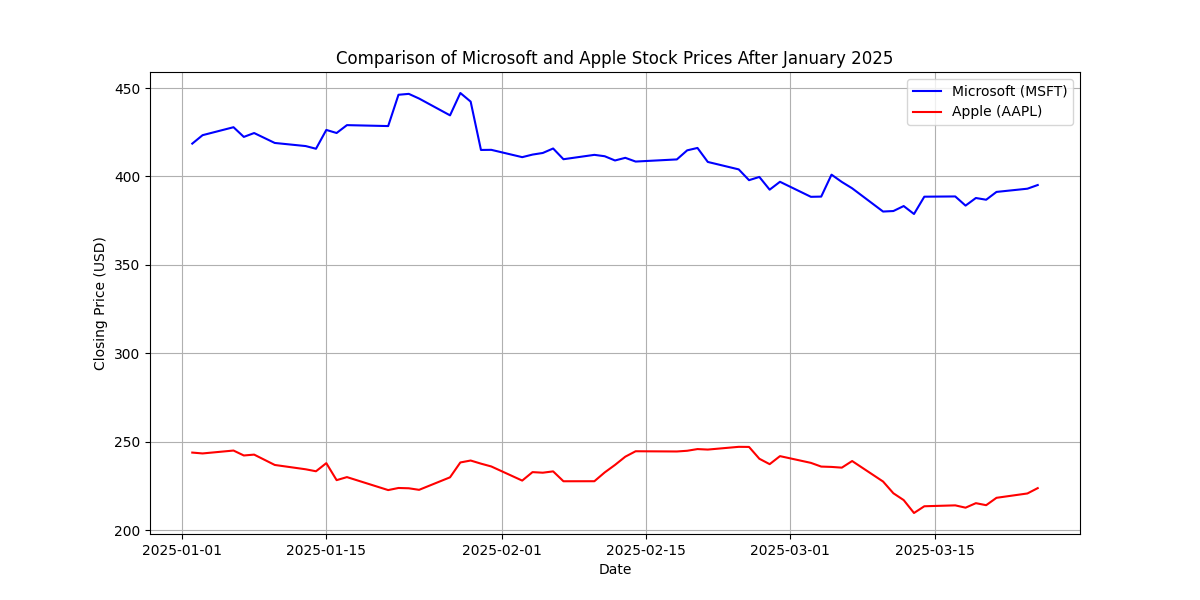

In [10]:
from IPython.display import Image
Image(filename=f"{executor.bind_dir}/result.png")  

AutoGen also supports a distributed agent runtime, which can host agents running on
different processes or machines, with different identities, languages and dependencies.

To learn how to use agent runtime, communication, message handling, and subscription, please continue
reading the sections following this quick start.